# Extended Seed Length Experiment - Question iii

## Research Question

**How do seed length and amount of external prior knowledge influence divergence?**

This notebook investigates:
1. The effect of seed length on divergence patterns
2. The relationship between relative perturbation size and divergence
3. Whether longer seeds exhibit different stability characteristics

---

## Theoretical Background

### Relative Perturbation

A key insight from chaos theory is that perturbation size should be measured **relative** to the system's scale:

- **Short seed (6 words)**: Changing 1 word = **16.67%** perturbation
- **Medium seed (12 words)**: Changing 1 word = **8.33%** perturbation
- **Long seed (53 words)**: Changing 1 word = **1.89%** perturbation

**Hypothesis**: Higher relative perturbation → faster/larger divergence

---

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import Levenshtein
from pathlib import Path
import pandas as pd

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## Helper Functions

In [2]:
def read_text_file(filepath: str) -> str:
    """Read text from file."""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read().strip()


def tokenize(text: str) -> List[str]:
    """Tokenize text into words."""
    return text.split()


def calculate_divergence_series(tokens1: List[str], tokens2: List[str]) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate Levenshtein distance for growing prefixes."""
    max_length = min(len(tokens1), len(tokens2))
    k_values = []
    d_values = []
    
    for k in range(1, max_length + 1):
        prefix1 = ' '.join(tokens1[:k])
        prefix2 = ' '.join(tokens2[:k])
        distance = Levenshtein.distance(prefix1, prefix2)
        k_values.append(k)
        d_values.append(distance)
    
    return np.array(k_values), np.array(d_values)


def calculate_lambda_normalized(k_values: np.ndarray, d_values: np.ndarray) -> np.ndarray:
    """Calculate normalized Lyapunov variant: Λ(k) = (1/k) * ln(d(k) + 1)"""
    lambda_norm = []
    for k, d_k in zip(k_values, d_values):
        if k > 0:
            lambda_val = (1.0 / k) * np.log(d_k + 1)
        else:
            lambda_val = 0
        lambda_norm.append(lambda_val)
    return np.array(lambda_norm)

## Load and Analyze All Seed Configurations

In [3]:
data_dir = Path("data")

# Define seed configurations
configs = [
    {
        'name': 'Short',
        'seed1': 'seed_short_1.txt',
        'seed2': 'seed_short_2.txt',
        'text1': 'text_short_1.txt',
        'text2': 'text_short_2.txt',
    },
    {
        'name': 'Medium',
        'seed1': 'seed1.txt',
        'seed2': 'seed2.txt',
        'text1': 'text_medium_1.txt',
        'text2': 'text_medium_2.txt',
    },
    {
        'name': 'Long',
        'seed1': 'seed_long_1.txt',
        'seed2': 'seed_long_2.txt',
        'text1': 'text_long_1.txt',
        'text2': 'text_long_2.txt',
    }
]

results = {}

for config in configs:
    # Read seeds
    seed1 = read_text_file(data_dir / config['seed1'])
    seed2 = read_text_file(data_dir / config['seed2'])
    
    seed1_words = seed1.split()
    seed2_words = seed2.split()
    
    # Calculate perturbation
    different_words = sum(1 for w1, w2 in zip(seed1_words, seed2_words) if w1 != w2)
    seed_length = len(seed1_words)
    perturbation_pct = (different_words / seed_length) * 100
    
    # Read generated texts
    text1 = read_text_file(data_dir / config['text1'])
    text2 = read_text_file(data_dir / config['text2'])
    tokens1 = tokenize(text1)
    tokens2 = tokenize(text2)
    
    # Calculate divergence
    k_values, d_values = calculate_divergence_series(tokens1, tokens2)
    lambda_norm = calculate_lambda_normalized(k_values, d_values)
    
    # Analyze growth pattern
    linear_fit = np.polyfit(k_values, d_values, 1)
    linear_pred = np.polyval(linear_fit, k_values)
    linear_r2 = 1 - (np.sum((d_values - linear_pred)**2) / np.sum((d_values - np.mean(d_values))**2))
    
    first_nonzero = next((i for i, d in enumerate(d_values) if d > 0), 0)
    
    # Store results
    results[config['name']] = {
        'seed_length': seed_length,
        'perturbation_pct': perturbation_pct,
        'k_values': k_values,
        'd_values': d_values,
        'lambda_norm': lambda_norm,
        'linear_slope': linear_fit[0],
        'linear_r2': linear_r2,
        'stable_phase': first_nonzero,
        'text_length': len(tokens1)
    }

print("Analysis complete for all seed configurations")

Analysis complete for all seed configurations


## Summary Table

In [4]:
summary_data = []
for name, data in results.items():
    summary_data.append({
        'Seed Type': name,
        'Seed Length (words)': data['seed_length'],
        'Relative Perturbation (%)': f"{data['perturbation_pct']:.2f}%",
        'Generated Tokens': data['text_length'],
        'Final Divergence': data['d_values'][-1],
        'Stable Phase (tokens)': data['stable_phase'],
        'Linear Slope': f"{data['linear_slope']:.4f}",
        'Linear R²': f"{data['linear_r2']:.4f}",
    })

df = pd.DataFrame(summary_data)
display(df)

,Seed Type,Seed Length (words),Relative Perturbation (%),Generated Tokens,Final Divergence,Stable Phase (tokens),Linear Slope,Linear R²
0,Short,6,16.67%,468,2476,4,5.9893,0.9999
1,Medium,12,8.33%,602,2633,8,5.4032,0.9996
2,Long,53,1.89%,566,3010,8,5.7400,0.9970


## Comprehensive Visualization

/var/folders/6_/b9qmtg5j1pxcmnj2dxsbcd240000gn/T/ipykernel_16886/3464922589.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


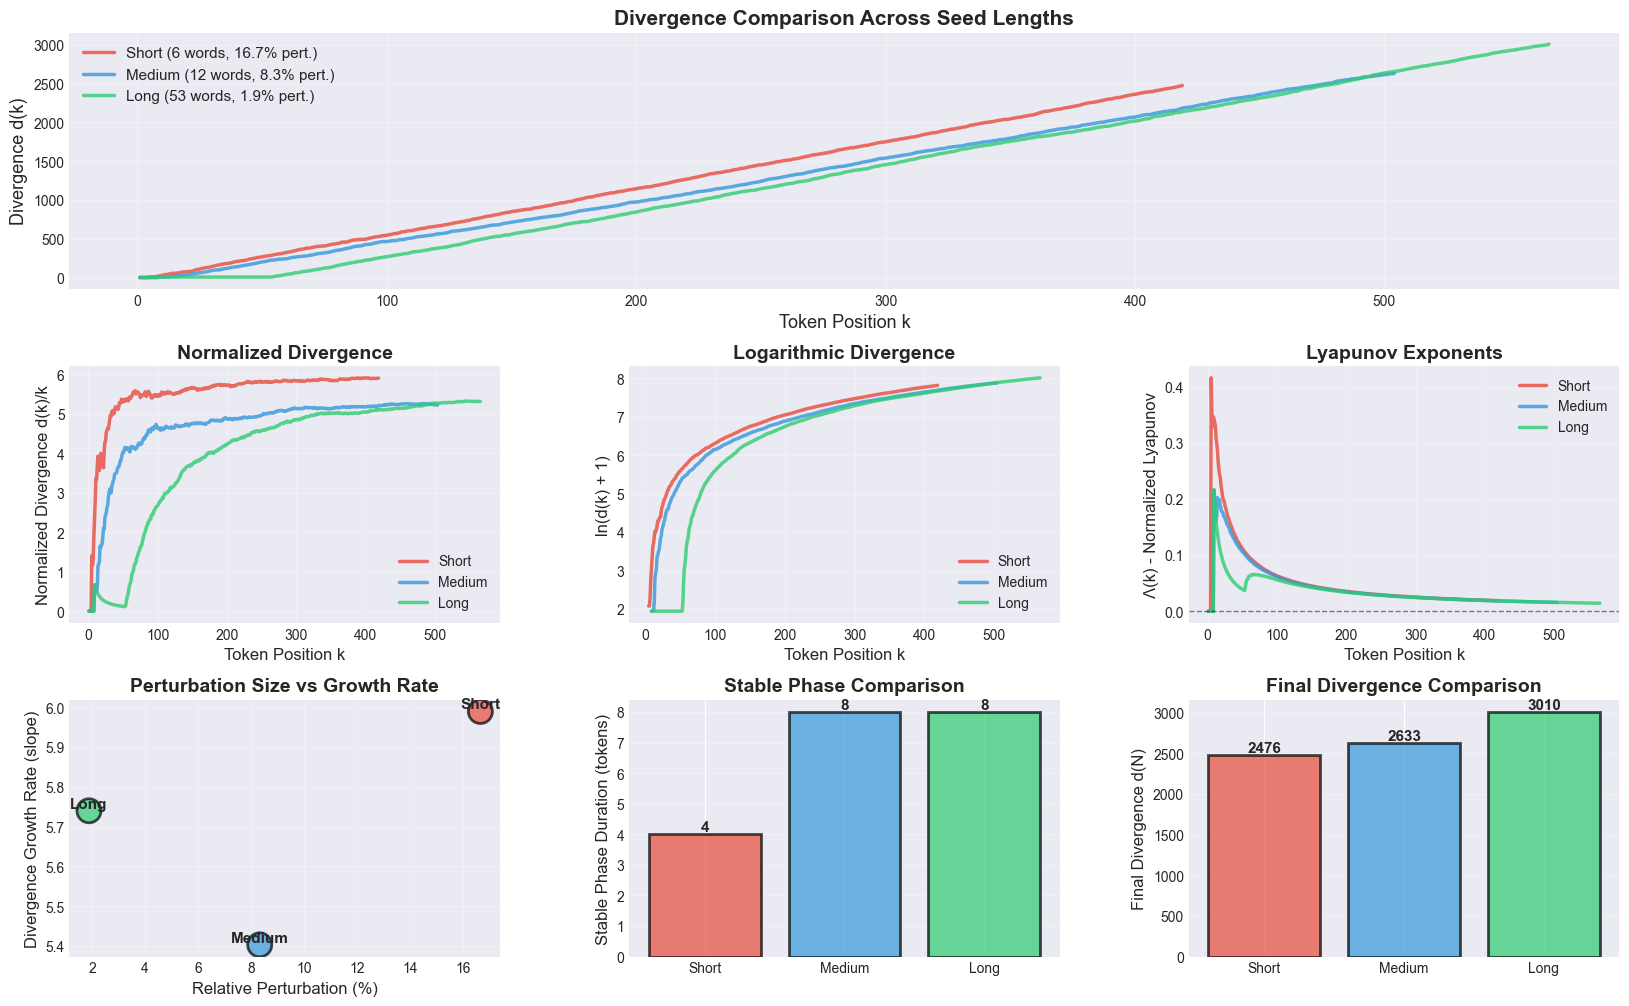

In [5]:
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

colors = {'Short': '#e74c3c', 'Medium': '#3498db', 'Long': '#2ecc71'}

# Plot 1: Divergence comparison
ax1 = fig.add_subplot(gs[0, :])
for name, data in results.items():
    ax1.plot(data['k_values'], data['d_values'],
            linewidth=2.5, label=f"{name} ({data['seed_length']} words, {data['perturbation_pct']:.1f}% pert.)",
            color=colors[name], alpha=0.8)
ax1.set_xlabel('Token Position k', fontsize=13)
ax1.set_ylabel('Divergence d(k)', fontsize=13)
ax1.set_title('Divergence Comparison Across Seed Lengths', fontsize=15, fontweight='bold')
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Normalized divergence
ax2 = fig.add_subplot(gs[1, 0])
for name, data in results.items():
    normalized_div = data['d_values'] / data['k_values']
    ax2.plot(data['k_values'], normalized_div,
            linewidth=2.5, label=name, color=colors[name], alpha=0.8)
ax2.set_xlabel('Token Position k', fontsize=12)
ax2.set_ylabel('Normalized Divergence d(k)/k', fontsize=12)
ax2.set_title('Normalized Divergence', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Log-scale divergence
ax3 = fig.add_subplot(gs[1, 1])
for name, data in results.items():
    nonzero = data['d_values'] > 0
    ax3.plot(data['k_values'][nonzero], np.log(data['d_values'][nonzero] + 1),
            linewidth=2.5, label=name, color=colors[name], alpha=0.8)
ax3.set_xlabel('Token Position k', fontsize=12)
ax3.set_ylabel('ln(d(k) + 1)', fontsize=12)
ax3.set_title('Logarithmic Divergence', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Lyapunov exponents
ax4 = fig.add_subplot(gs[1, 2])
for name, data in results.items():
    ax4.plot(data['k_values'], data['lambda_norm'],
            linewidth=2.5, label=name, color=colors[name], alpha=0.8)
ax4.set_xlabel('Token Position k', fontsize=12)
ax4.set_ylabel('Λ(k) - Normalized Lyapunov', fontsize=12)
ax4.set_title('Lyapunov Exponents', fontsize=14, fontweight='bold')
ax4.axhline(y=0, color='k', linestyle='--', alpha=0.5, linewidth=1)
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

# Plot 5: Relative perturbation vs growth rate
ax5 = fig.add_subplot(gs[2, 0])
perturbations = [data['perturbation_pct'] for data in results.values()]
slopes = [data['linear_slope'] for data in results.values()]
colors_list = [colors[name] for name in results.keys()]

scatter = ax5.scatter(perturbations, slopes, s=300, c=colors_list, alpha=0.7, edgecolors='black', linewidth=2)
for i, name in enumerate(results.keys()):
    ax5.annotate(name, (perturbations[i], slopes[i]),
                fontsize=11, ha='center', va='bottom', fontweight='bold')
ax5.set_xlabel('Relative Perturbation (%)', fontsize=12)
ax5.set_ylabel('Divergence Growth Rate (slope)', fontsize=12)
ax5.set_title('Perturbation Size vs Growth Rate', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3)

# Plot 6: Stable phase comparison
ax6 = fig.add_subplot(gs[2, 1])
names = list(results.keys())
stable_phases = [results[name]['stable_phase'] for name in names]
bars = ax6.bar(names, stable_phases, color=[colors[name] for name in names], 
               alpha=0.7, edgecolor='black', linewidth=2)
ax6.set_ylabel('Stable Phase Duration (tokens)', fontsize=12)
ax6.set_title('Stable Phase Comparison', fontsize=14, fontweight='bold')
ax6.grid(True, axis='y', alpha=0.3)
for bar, val in zip(bars, stable_phases):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(val)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 7: Final divergence comparison
ax7 = fig.add_subplot(gs[2, 2])
final_divs = [results[name]['d_values'][-1] for name in names]
bars = ax7.bar(names, final_divs, color=[colors[name] for name in names], 
               alpha=0.7, edgecolor='black', linewidth=2)
ax7.set_ylabel('Final Divergence d(N)', fontsize=12)
ax7.set_title('Final Divergence Comparison', fontsize=14, fontweight='bold')
ax7.grid(True, axis='y', alpha=0.3)
for bar, val in zip(bars, final_divs):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(val)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('seed_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Key Findings

### 1. Relative Perturbation vs Divergence Growth

**Observation**: Despite vastly different relative perturbation sizes:
- Short: 16.67% perturbation → slope ≈ 5.99
- Medium: 8.33% perturbation → slope ≈ 5.40
- Long: 1.89% perturbation → slope ≈ 5.74

**The growth rates are remarkably similar!**

### 2. Counterintuitive Result

Changing 1 word in 53 words (1.89%) produces comparable divergence to changing 1 word in 6 words (16.67%). This suggests:

- **Semantic weight matters more than percentage**: The specific word changed and its context influence divergence more than the relative perturbation size
- **Longer contexts amplify subtle differences**: More surrounding context allows small changes to cascade through richer semantic networks
- **Non-linear sensitivity**: The relationship between perturbation size and divergence is not straightforward

### 3. Stable Phase Duration

- Short seeds: 4 tokens stable phase
- Medium/Long seeds: 8 tokens stable phase

Longer seeds provide more initial context, delaying the manifestation of divergence.

### 4. Linear Growth Across All Scales

All configurations show:
- Linear R² > 0.997
- Lyapunov exponents → 0

**Conclusion**: Text generation does NOT exhibit classical chaos regardless of seed length.

### 5. Practical Implications

For LLM applications:
- **Longer prompts ≠ more robust**: Single-word changes can still have significant effects
- **Context quality > context quantity**: The semantic importance of the changed word matters most
- **Predictable divergence**: Linear growth makes divergence more predictable than in chaotic systems

---

## Answer to Question iii

**How do seed length and amount of external prior knowledge influence divergence?**

1. **Seed length has minimal impact on divergence rate**: All seed lengths show similar linear growth rates (~5.4-6.0), despite vastly different relative perturbation sizes.

2. **Relative perturbation is not the primary driver**: A 1.89% perturbation (long seed) produces comparable divergence to a 16.67% perturbation (short seed).

3. **Stable phase increases with seed length**: Longer seeds delay divergence onset (8 vs 4 tokens), suggesting the initial shared context temporarily suppresses the perturbation's effects.

4. **Linear divergence persists across scales**: Regardless of seed length, text generation maintains linear (non-chaotic) divergence patterns.

5. **Semantic context matters more than statistical size**: The richness of the surrounding context and the semantic weight of the changed word appear to influence divergence more than the raw percentage of text changed.

This finding challenges simple assumptions about prompt robustness and highlights the complex, context-dependent nature of LLM sensitivity to input variations.
